In [1]:
#from ssm.models import SLDS
#from ssm.emissions import GaussianIdentityEmissions
#from ssm.variational import SLDSMeanFieldVariationalPosterior, SLDSTriDiagVariationalPosterior
import ssm
import numpy as np
import scipy.io
#from pybasicbayes.util.text import progprint_xrange
import matplotlib.pyplot as plt
from ssm.util import random_rotation, find_permutation
import pandas as pd

In [2]:
N_array = np.array([6,12,24,50,100,200,400,1000,2000,4000])
Kmax = 4
num_steps = 161
table_file = "../data/smooth_comparison_output_rank6.csv"
output_file = "../data/smooth_comparison_final_rank6.csv"

In [3]:
def fit_slds_and_return_errors(X, A1, A2, Kmax=2, r=6, num_iters=2000):
    '''
    Fit an SLDS to test data and return errors.
    
    Parameters
    ==========
    
    X : array, T x N
    A1 : array, N x N
    A2 : array, N x N
    '''
    from numpy.linalg import norm
    # params
    N = X.shape[1]
    T = X.shape[0]
    # fit a model
    slds = ssm.SLDS(N, Kmax, r)
    #slds.initialize(X)
    #q_mf = SLDSMeanFieldVariationalPosterior(slds, X)
    q_elbos, q_struct = slds.fit(X, num_iters=num_iters, initialize=True)
    q_struct_x = q_struct.mean_continuous_states[0]
    # predict states
    true_states = np.array([0 if i < T/2 else 1 for i in range(T)])
    slds.permute(find_permutation(true_states, slds.most_likely_states(q_struct_x, X)))
    pred_states = slds.most_likely_states(q_struct_x, X)
    print("predicted states:")
    print(pred_states)
    # extract predicted A1, A2 matrices
    A_r = slds.dynamics.As
    b_r = slds.dynamics.bs
    Cs = slds.emissions.Cs[0]
    A1_pred = Cs @ A_r[0] @ np.linalg.pinv(Cs)
    A2_pred = Cs @ A_r[1] @ np.linalg.pinv(Cs)
    # compare inferred and true
    #err_inf = 0.5 * (np.max(np.abs(A1_pred[:] - A1[:])) + \
    #                 np.max(np.abs(A2_pred[:] - A2[:])))
    #err_2 = 0.5 * (norm(A1_pred - A1, 2) + \
    #               norm(A2_pred - A2, 2))
    #err_fro = 0.5 * (norm(A1_pred - A1, 'fro') + \
    #                 norm(A2_pred - A2, 'fro'))
    err_mse = 0.
    err_inf = 0.
    err_2 = 0.
    err_fro = 0.
    for t in range(T-1):
        if true_states[t] == 0:
            A_true = A1
        else:
            A_true = A2
        A_r = slds.dynamics.As[pred_states[t]]
        A_pred = Cs @ A_r @ np.linalg.pinv(Cs)
        xpred = A_pred @ X[t, :].T + Cs @ b_r[pred_states[t]]
        err_mse += norm(xpred - X[t+1, :], 2)**2
        err_inf += np.max(np.abs(A_pred[:] - A_true[:]))
        err_2 += norm(A_pred - A_true, 2)
        err_fro += norm(A_pred - A_true, 'fro')
    err_mse /= float(N * (T - 1))
    err_inf /= float(T - 1)
    err_2 /= float(T - 1)
    err_fro /= float(T - 1)
    return (err_inf, err_2, err_fro, err_mse)

In [4]:
error_table = pd.read_csv(table_file)
print(error_table.tail())
print(error_table.columns)
#error_table = pd.DataFrame(columns = ['N', 'window', 'model', 'err_inf', 'err_2', 'err_fro', 'model_MSE', \
#                    'true_MSE'])

         N  window  model   err_inf     err_2   err_fro  model_MSE  true_MSE
4795  4000     156      3  0.001293  1.021531  1.022492   0.040099  0.041044
4796  4000     157      3  0.001257  0.990213  0.991269   0.039281  0.039894
4797  4000     158      3  0.001265  1.007178  1.008136   0.038797  0.039508
4798  4000     159      3  0.001207  0.966917  0.967889   0.040014  0.040349
4799  4000     160      3  0.001170  0.962547  0.963584   0.040408  0.040920
Index(['N', 'window', 'model', 'err_inf', 'err_2', 'err_fro', 'model_MSE',
       'true_MSE'],
      dtype='object')


## Fit SLDS with rank r = 4 & r = 6

In [5]:
for N in N_array[N_array > 6]:
    data = scipy.io.loadmat("../data/test_data_smooth_N_%d_M_%d_sigma_0.200000.mat" % (N, num_steps))
    X = data['X']
    thetas = data['thetas'].flatten()
    U = data['U']
    err_inf, err_2, err_fro, err_mse = \
        fit_slds_and_return_errors(X.T, thetas, U, Kmax=Kmax, r=6, num_iters=2000)
    print("N = %d : err_inf = %f, err_2 = %f, err_fro = %f, err_mse = %f" % \
           (N, err_inf, err_2, err_fro, err_mse))

    new_row = dict(zip(error_table.columns, 
                       [N, np.nan, 4, err_inf, err_2, err_fro, err_mse, np.nan]))
    error_table = error_table.append(new_row, ignore_index=True)

Initializing with an ARHMM using 25 steps of EM.


KeyboardInterrupt: 

In [39]:
## TODO!!!! load output again and re-append, remake plots, save csv


error_table = error_table.append(error_table_save, ignore_index=True)
print(error_table)

           N  window  model   err_inf      err_2    err_fro     model_MSE  \
0        6.0     1.0    1.0  0.420547   1.005800   1.042555  1.933072e-31   
1        6.0     2.0    1.0  0.471552   1.031197   1.062269  2.614129e-31   
2        6.0     3.0    1.0  0.431601   1.000176   1.016065  5.392604e-32   
3        6.0     4.0    1.0  0.433866   1.018973   1.041232  2.673833e-32   
4        6.0     5.0    1.0  0.407146   1.019883   1.034634  1.694818e-32   
5        6.0     6.0    1.0  0.405515   1.019317   1.058727  1.900251e-32   
6        6.0     7.0    1.0  0.470935   1.049119   1.133574  0.000000e+00   
7        6.0     8.0    1.0  0.399011   1.001558   1.082659  1.283953e-34   
8        6.0     9.0    1.0  0.434879   1.004715   1.141852  3.286920e-32   
9        6.0    10.0    1.0  0.433734   1.003845   1.035680  0.000000e+00   
10       6.0    11.0    1.0  0.472231   1.001863   1.056845  4.211367e-32   
11       6.0    12.0    1.0  0.423876   1.020407   1.068217  4.930381e-32   

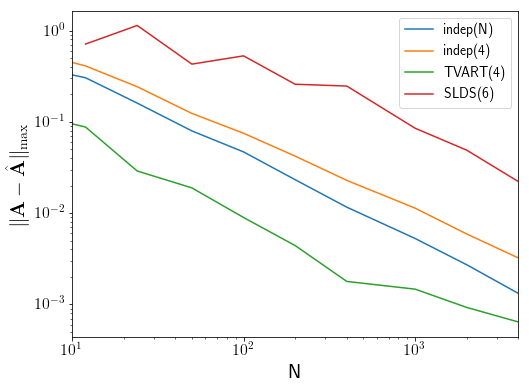

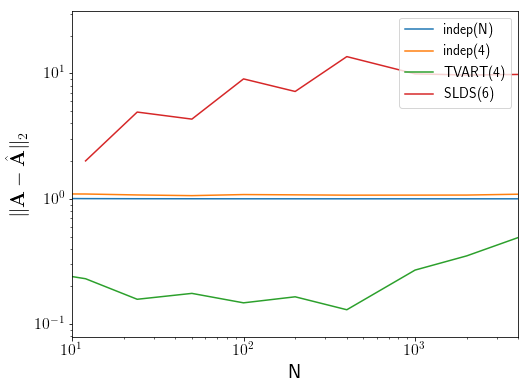

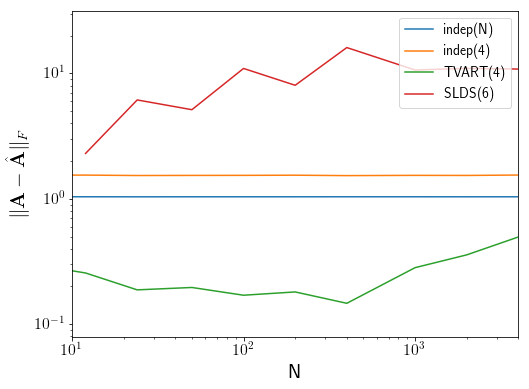

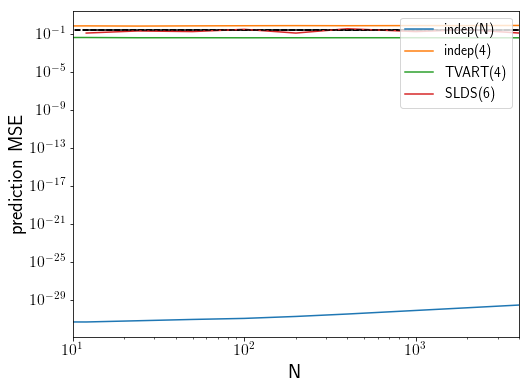

In [56]:
data = error_table

import matplotlib
#plt.loglog(data['N'], data['err_2'])

plot_type = 'err_2'
plt.rc('text', usetex=True)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams.update({'font.size': 16})


for plot_type in ['err_inf', 'err_2', 'err_fro', 'model_MSE']:
    fig, ax = plt.subplots(figsize=(8,6))
    for key, grp in data.groupby(['model']):
        grp = grp.groupby(['N']).mean()
        if key == 1:
            keystr = 'indep(N)'
        elif key == 2:
            keystr = 'indep(4)'
        elif key == 3:
            keystr = 'TVART(4)'
        elif key == 4:
            keystr = 'SLDS(6)'
        elif key == 5:
            keystr = 'SLDS(6)'
        ax = grp.plot(ax=ax, kind='line', y=plot_type, label=keystr, logx=True, logy=True)

    #plt.ylim([1e-2, 1e-1])
        plt.legend(loc='upper right', fontsize=14)
        plt.xlabel('N', fontsize=20)
        if plot_type == 'err_inf':
            plt.ylabel("$\| \mathbf{A} - \hat{\mathbf{A}} \|_\mathrm{max}$", fontsize=20)
        elif plot_type == 'err_2':
            plt.ylabel("$\| \mathbf{A} - \hat{\mathbf{A}} \|_{2}$", fontsize=20)
            plt.ylim([10**-1.1, 10**1.5])
        elif plot_type == 'err_fro':
            plt.ylabel("$\| \mathbf{A} - \hat{\mathbf{A}} \|_F$", fontsize=20)
            plt.ylim([10**-1.1, 10**1.5])
        elif plot_type == 'model_MSE':
            plt.ylabel("prediction MSE", fontsize=20)
            plt.plot([min(grp.index), max(grp.index)], [0.25, 0.25], 'k--')
            #plt.ylim([10**-1, 10**0.5])
        
    plt.xlim([10, 4*10**3])
    plt.savefig("../figures/smooth_compare_" + plot_type + ".eps")
    plt.show()

#data.plot.line(x='N', y='err_inf', logx=True, logy=True)

In [29]:
error_table.tail()

,N,window,model,err_inf,err_2,err_fro,model_MSE,true_MSE
4805,200.0,NaN,4.0,0.258043,7.172370,8.035514,0.123208,NaN
4806,400.0,NaN,4.0,0.246560,13.600222,16.058434,0.350887,NaN
4807,1000.0,NaN,4.0,0.085104,9.908913,10.634993,0.175730,NaN
4808,2000.0,NaN,4.0,0.048900,9.702654,10.967202,0.280857,NaN
4809,4000.0,NaN,4.0,0.022148,9.803067,10.820141,0.124669,NaN


In [30]:
error_table.to_csv(output_file, header=True, index=False)

In [11]:
norm_vector = np.zeros((len(N_array), 3))
for i, N in enumerate(N_array):
    data = scipy.io.loadmat("test_data_N_%d_M_201_sigma_0.500000.mat" % N)
    X = data['X']
    A1 = data['A1']
    A2 = data['A2']
    norm_vector[i, 0] = 0.5 * (np.max(np.abs(A1.ravel())) +  np.max(np.abs(A2.ravel())))
    norm_vector[i, 1] = 0.5 * (np.linalg.norm(A1, 2) +  np.linalg.norm(A2, 2))
    norm_vector[i, 2] = 0.5 * (np.linalg.norm(A1, 'fro') +  np.linalg.norm(A2, 'fro'))

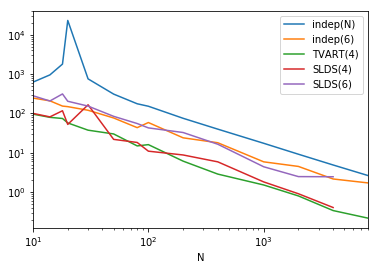

In [12]:
data = error_table
#plt.loglog(data['N'], data['err_2'])
fig, ax = plt.subplots()

for key, grp in data.groupby(['model']):
    grp = grp.groupby(['N']).mean()
    if key == 1:
        keystr = 'indep(N)'
    elif key == 2:
        keystr = 'indep(6)'
    elif key == 3:
        keystr = 'TVART(4)'
    elif key == 4:
        keystr = 'SLDS(4)'
    elif key == 5:
        keystr = 'SLDS(6)'
    grp = grp.iloc[grp.index >= min(N_array)]
    grp['err_inf'] /= norm_vector[i, 0]
    grp['err_2']   /= norm_vector[i, 1]
    grp['err_fro'] /= norm_vector[i, 2]
    ax = grp.plot(ax=ax, kind='line', y='err_inf', label=keystr, logx=True, logy=True)

plt.legend(loc='best')
#plt.ylim([1e-2, 1e-1])
plt.show()
